In [1]:
# Full Corrected Code
!pip install -q transformers datasets peft accelerate bitsandbytes pandas scikit-learn
!pip install -U datasets transformers

In [1]:
from sklearn.metrics import accuracy_score  # Add this line
import pandas as pd
import json
import torch
import numpy as np
from sklearn.model_selection import train_test_split
from datasets import load_dataset
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    AutoModelForCausalLM, TrainingArguments, Trainer,
    BitsAndBytesConfig, DataCollatorForLanguageModeling
)
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training
import matplotlib.pyplot as plt


In [2]:
# Configuration
DATA_PATH = "/content/mushrooms_1.csv"
RANDOM_SEED = 42
TEST_SIZE = 0.2

# 1. Data Preparation
print("\n=== Loading and Preparing Data ===")

# Load CSV with validation
try:
    df = pd.read_csv(DATA_PATH, sep=',')
    print("Data loaded successfully. Shape:", df.shape)
except FileNotFoundError:
    raise FileNotFoundError(f"CSV file not found at {DATA_PATH}. Upload your data first!")

# Complete Feature Mapping
FEATURE_MAP = {
    'class': {'e': 'edible', 'p': 'poisonous'},
    'cap-shape': {'b': 'bell', 'c': 'conical', 'x': 'convex', 'f': 'flat', 'k': 'knobbed', 's': 'sunken'},
    'cap-surface': {'f': 'fibrous', 'g': 'grooves', 'y': 'scaly', 's': 'smooth'},
    'cap-color': {'n': 'brown', 'b': 'buff', 'c': 'cinnamon', 'g': 'gray', 'r': 'green',
                 'p': 'pink', 'u': 'purple', 'e': 'red', 'w': 'white', 'y': 'yellow'},
    'bruises': {'t': 'bruises present', 'f': 'no bruises'},
    'odor': {'a': 'almond', 'l': 'anise', 'c': 'creosote', 'y': 'fishy', 'f': 'foul',
            'm': 'musty', 'n': 'none', 'p': 'pungent', 's': 'spicy'},
    'gill-attachment': {'a': 'attached', 'd': 'descending', 'f': 'free', 'n': 'notched'},
    'gill-spacing': {'c': 'close', 'w': 'crowded', 'd': 'distant'},
    'gill-size': {'b': 'broad', 'n': 'narrow'},
    'gill-color': {'k': 'black', 'n': 'brown', 'b': 'buff', 'h': 'chocolate', 'g': 'gray',
                  'r': 'green', 'o': 'orange', 'p': 'pink', 'u': 'purple', 'e': 'red',
                  'w': 'white', 'y': 'yellow'},
    'stalk-shape': {'e': 'enlarging', 't': 'tapering'},
    'stalk-root': {'b': 'bulbous', 'c': 'club', 'u': 'cup', 'e': 'equal', 'z': 'rhizomorphs',
                  'r': 'rooted', '?': 'missing'},
    'stalk-surface-above-ring': {'f': 'fibrous', 'y': 'scaly', 'k': 'silky', 's': 'smooth'},
    'stalk-surface-below-ring': {'f': 'fibrous', 'y': 'scaly', 'k': 'silky', 's': 'smooth'},
    'stalk-color-above-ring': {'n': 'brown', 'b': 'buff', 'c': 'cinnamon', 'g': 'gray',
                              'o': 'orange', 'p': 'pink', 'e': 'red', 'w': 'white', 'y': 'yellow'},
    'stalk-color-below-ring': {'n': 'brown', 'b': 'buff', 'c': 'cinnamon', 'g': 'gray',
                              'o': 'orange', 'p': 'pink', 'e': 'red', 'w': 'white', 'y': 'yellow'},
    'veil-type': {'p': 'partial', 'u': 'universal'},
    'veil-color': {'n': 'brown', 'o': 'orange', 'w': 'white', 'y': 'yellow'},
    'ring-number': {'n': 'none', 'o': 'one', 't': 'two'},
    'ring-type': {'c': 'cobwebby', 'e': 'evanescent', 'f': 'flaring', 'l': 'large',
                 'n': 'none', 'p': 'pendant', 's': 'sheathing', 'z': 'zone'},
    'spore-print-color': {'k': 'black', 'n': 'brown', 'b': 'buff', 'h': 'chocolate',
                         'r': 'green', 'o': 'orange', 'u': 'purple', 'w': 'white', 'y': 'yellow'},
    'population': {'a': 'abundant', 'c': 'clustered', 'n': 'numerous',
                  's': 'scattered', 'v': 'several', 'y': 'solitary'},
    'habitat': {'g': 'grasses', 'l': 'leaves', 'm': 'meadows', 'p': 'paths',
               'u': 'urban', 'w': 'waste', 'd': 'woods'}
}


=== Loading and Preparing Data ===
Data loaded successfully. Shape: (8124, 23)


In [3]:
# Generate descriptions
def map_features(row):
    features = []
    for col in df.columns:
        if col == 'class': continue
        try:
            mapped = FEATURE_MAP[col][row[col]]
            features.append(f"{col.replace('-', ' ')}: {mapped}")
        except KeyError as e:
            raise ValueError(f"Missing mapping for {col} value: {row[col]}") from e
    return ', '.join(features)

df['description'] = df.apply(map_features, axis=1)
df['label'] = df['class'].map(FEATURE_MAP['class'])

# Create prompt datasets
print("\n=== Generating Training Files ===")
for style in ['short', 'verbose', 'cot']:
    data = []
    for _, row in df.iterrows():
        prompt = {
            "instruction": "Classify mushroom" if style == "short" else "Analyze mushroom characteristics",
            "input": row['description'],
            "output": row['label']
        }
        data.append(prompt)

    train, test = train_test_split(data, test_size=TEST_SIZE, random_state=RANDOM_SEED)

    for split, split_data in [('train', train), ('test', test)]:
        filename = f"mushroom_{style}_{split}.jsonl"
        with open(filename, 'w') as f:
            for item in split_data:
                f.write(json.dumps(item) + '\n')
        print(f"Created {filename} with {len(split_data)} samples")




=== Generating Training Files ===
Created mushroom_short_train.jsonl with 6499 samples
Created mushroom_short_test.jsonl with 1625 samples
Created mushroom_verbose_train.jsonl with 6499 samples
Created mushroom_verbose_test.jsonl with 1625 samples
Created mushroom_cot_train.jsonl with 6499 samples
Created mushroom_cot_test.jsonl with 1625 samples


In [14]:
from datasets import load_dataset
from transformers import AutoTokenizer

# Load test dataset again
dataset = load_dataset('json', data_files={
    'test': 'mushroom_short_test.jsonl'
})

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

def preprocess(examples):
    text = [f"{inst} {inp}" for inst, inp in zip(examples['instruction'], examples['input'])]
    tokenized = tokenizer(
        text,
        truncation=True,
        padding='max_length',
        max_length=256
    )
    tokenized['labels'] = [0 if label == 'edible' else 1 for label in examples['output']]
    return tokenized

tokenized_ds = dataset.map(preprocess, batched=True)


Generating test split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/1625 [00:00<?, ? examples/s]

In [7]:
# 2. Model Training
MODELS_CONFIG = {
    "distilbert": {
        "name": "distilbert-base-uncased",
        "lora": {
            "r": 8,
            "lora_alpha": 16,
            "target_modules": ["q_lin", "v_lin"],
            "lora_dropout": 0.1
        }
    }
}

def train_classification_model():
    print("\n=== Training DistilBERT ===")

    # Load dataset
    from datasets import load_dataset
    dataset = load_dataset('json', data_files={
        'train': 'mushroom_short_train.jsonl',
        'test': 'mushroom_short_test.jsonl'
    })

    # Tokenization with labels
    tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

    def preprocess(examples):
        text = [f"{inst} {inp}" for inst, inp in zip(examples['instruction'], examples['input'])]
        tokenized = tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=256
        )
        tokenized['labels'] = [0 if label == 'edible' else 1 for label in examples['output']]
        return tokenized

    tokenized_ds = dataset.map(preprocess, batched=True)

    # Model setup with label mappings
    model = AutoModelForSequenceClassification.from_pretrained(
        "distilbert-base-uncased",
        num_labels=2,
        id2label={0: "edible", 1: "poisonous"},
        label2id={"edible": 0, "poisonous": 1}
    )

    peft_config = LoraConfig(task_type="SEQ_CLS", **MODELS_CONFIG["distilbert"]["lora"])
    model = get_peft_model(model, peft_config)

    # Training arguments
    training_args = TrainingArguments(
        output_dir='./results',
        learning_rate=2e-5,
        per_device_train_batch_size=2,
        per_device_eval_batch_size=1,
        num_train_epochs=3,
        eval_strategy="epoch",
        logging_steps=50,
        save_strategy="epoch",
        seed=RANDOM_SEED,
        report_to="none"
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_ds['train'],
        eval_dataset=tokenized_ds['test'],
        compute_metrics=lambda p: {
            'accuracy': accuracy_score(p.label_ids, np.argmax(p.predictions, axis=1))
        }
    )

    print("Starting training...")
    trainer.train()
    return model, trainer

In [8]:
# Execute full pipeline
if __name__ == "__main__":
    # First create the data files
    print("\n=== Data Preparation Phase ===")
    # (Data preparation code above)

    # Then train the model
    model, trainer = train_classification_model()
    print("\n=== Training Complete ===")


=== Data Preparation Phase ===

=== Training DistilBERT ===


Map:   0%|          | 0/1625 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Starting training...


Epoch,Training Loss,Validation Loss,Accuracy
1,0.104700,0.078750,0.984615
2,0.094000,0.083098,0.984615
3,0.094600,0.083663,0.984615



=== Training Complete ===


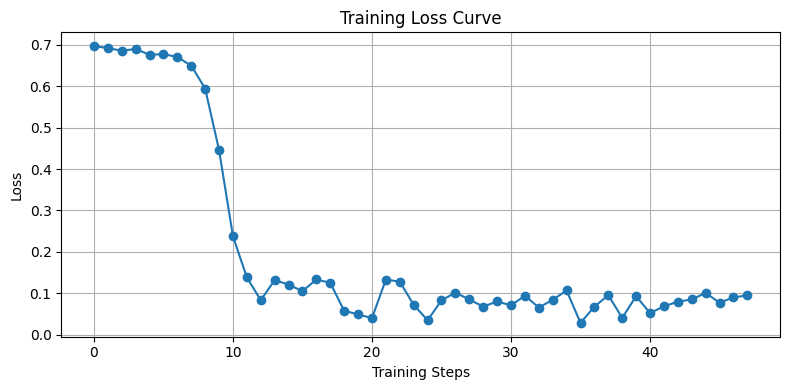

✅ Plot saved as 'loss_curve.png'


In [9]:
import matplotlib.pyplot as plt

# Extract training losses
losses = [log['loss'] for log in trainer.state.log_history if 'loss' in log]

# Plot and save the training loss curve
plt.figure(figsize=(8, 4))
plt.plot(losses, marker='o')
plt.title("Training Loss Curve")
plt.xlabel("Training Steps")
plt.ylabel("Loss")
plt.grid(True)
plt.tight_layout()
plt.savefig("loss_curve.png")
plt.show()

print("Plot saved as 'loss_curve.png'")


In [15]:
from sklearn.metrics import classification_report

predictions = trainer.predict(tokenized_ds["test"])
preds = predictions.predictions.argmax(axis=1)
labels = predictions.label_ids

print("=== Fine-Tuned Classification Report ===")
print(classification_report(labels, preds, target_names=["edible", "poisonous"]))


=== Fine-Tuned Classification Report ===
              precision    recall  f1-score   support

      edible       0.97      1.00      0.99       843
   poisonous       1.00      0.97      0.98       782

    accuracy                           0.98      1625
   macro avg       0.99      0.98      0.98      1625
weighted avg       0.99      0.98      0.98      1625



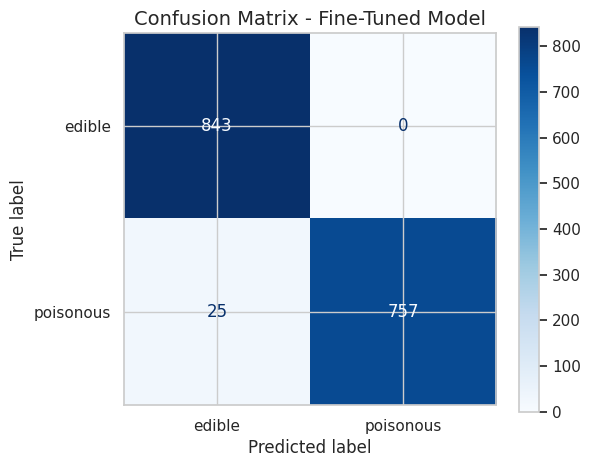

In [16]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Create the confusion matrix
cm = confusion_matrix(labels, preds)

# Step 2: Plot the confusion matrix
sns.set(style="whitegrid")
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["edible", "poisonous"])

fig, ax = plt.subplots(figsize=(6, 5))
disp.plot(cmap='Blues', ax=ax, values_format='d')
plt.title("Confusion Matrix - Fine-Tuned Model", fontsize=14)
plt.savefig("confusion_matrix.png")
plt.show()


In [17]:
# Sample unseen mushroom description
new_description = "cap shape: convex, cap color: brown, odor: foul, gill size: broad, habitat: woods"
instruction = "Classify mushroom"
full_prompt = f"{instruction} {new_description}"

# Tokenize and predict
inputs = tokenizer(full_prompt, return_tensors="pt", padding=True, truncation=True).to(model.device)
outputs = model(**inputs)
predicted_class = torch.argmax(outputs.logits, dim=1).item()

# Map back to label
label = model.config.id2label[predicted_class]
print("🧠 Prediction for unseen prompt:", label)


🧠 Prediction for unseen prompt: poisonous


In [18]:
import torch
import pandas as pd
from transformers import AutoTokenizer

# Load tokenizer and fine-tuned model (already trained and loaded in your code)
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
model.eval()  # set to inference mode

# Create a few UNSEEN mushroom prompts (not from train/test set)
unseen_prompts = [
    "cap shape: convex, cap color: brown, odor: foul, gill size: broad, habitat: woods",
    "cap shape: bell, cap color: white, odor: almond, gill size: narrow, habitat: urban",
    "cap shape: flat, cap color: yellow, odor: pungent, gill size: broad, habitat: grasses",
    "cap shape: sunken, cap color: red, odor: spicy, gill size: narrow, habitat: leaves",
    "cap shape: knobbed, cap color: pink, odor: musty, gill size: broad, habitat: paths"
]

# Run inference on each prompt
results = []
for prompt in unseen_prompts:
    input_text = f"Classify mushroom {prompt}"
    inputs = tokenizer(input_text, return_tensors="pt", padding=True, truncation=True).to(model.device)
    with torch.no_grad():
        outputs = model(**inputs)
        probs = torch.nn.functional.softmax(outputs.logits, dim=1)
        predicted_class = torch.argmax(probs, dim=1).item()
        label = model.config.id2label[predicted_class]
        confidence = probs[0][predicted_class].item()

    results.append({
        "Prompt": prompt,
        "Prediction": label,
        "Confidence": round(confidence, 4)
    })

# Display results as a table
df = pd.DataFrame(results)
print("\n=== Inference on Unseen Prompts ===")
print(df.to_string(index=False))



=== Inference on Unseen Prompts ===
                                                                               Prompt Prediction  Confidence
    cap shape: convex, cap color: brown, odor: foul, gill size: broad, habitat: woods  poisonous      0.9981
   cap shape: bell, cap color: white, odor: almond, gill size: narrow, habitat: urban  poisonous      0.8820
cap shape: flat, cap color: yellow, odor: pungent, gill size: broad, habitat: grasses  poisonous      0.9955
   cap shape: sunken, cap color: red, odor: spicy, gill size: narrow, habitat: leaves  poisonous      0.9965
   cap shape: knobbed, cap color: pink, odor: musty, gill size: broad, habitat: paths  poisonous      0.9913


## 🧠 GPT2 Fine-Tuning (Second Model - Generation Based)

In [6]:
# GPT-2 Implementation with 4-bit Quant + LoRA (Memory Optimized)
!pip install -q -U transformers datasets peft accelerate bitsandbytes pandas


In [1]:
import torch
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    TrainingArguments,
    Trainer,
    DataCollatorForLanguageModeling,
    BitsAndBytesConfig
)
from datasets import load_dataset
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training
import numpy as np
from gc import collect


In [51]:
# Memory optimization
%env PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True
torch.cuda.empty_cache()

# 1. Data Loading
dataset = load_dataset('json', data_files={
    'train': 'mushroom_short_train.jsonl',
    'test': 'mushroom_short_test.jsonl'
})

# Use only 50% of training and test set
train_half = dataset['train'].select(range(len(dataset['train']) // 2))
test_half = dataset['test'].select(range(len(dataset['test']) // 2))

# Replace original dataset
dataset = {
    'train': train_half,
    'test': test_half
}

# 2. Model Setup
model_id = "gpt2"
tokenizer = AutoTokenizer.from_pretrained(model_id)
tokenizer.pad_token = tokenizer.eos_token

# 4-bit Quantization
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16
)

# Load Model with Memory Optimizations
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    quantization_config=bnb_config,
    device_map="auto",
    use_cache=False  # Disable cache for gradient checkpointing
)
model.gradient_checkpointing_enable()
model = prepare_model_for_kbit_training(model)

env: PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True


In [52]:
# 3. LoRA Configuration
peft_config = LoraConfig(
    r=4,  # Reduced from 8 for memory
    lora_alpha=16,
    target_modules=["c_attn"],  # GPT-2 specific
    lora_dropout=0.1,
    bias="none",
    task_type="CAUSAL_LM"
)
model = get_peft_model(model, peft_config)



In [53]:
def format_function(examples):
    prompts = [
        f"Classify mushroom: {inp}\nAnswer:"
        for inp in examples["input"]
    ]
    answers = [f" {out}" for out in examples["output"]]

    full_texts = [p + a for p, a in zip(prompts, answers)]

    tokenized = tokenizer(
        full_texts,
        truncation=True,
        padding="max_length",
        max_length=128,
        return_tensors="pt"
    )

    # Set the same input_ids as labels (causal LM)
    tokenized["labels"] = tokenized["input_ids"].clone()
    return tokenized


In [56]:
tokenized_ds = {}

for split in ['train', 'test']:
    tokenized_ds[split] = dataset[split].map(
        format_function,
        batched=True,
        remove_columns=dataset[split].column_names
    )
    tokenized_ds[split].set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])


Map:   0%|          | 0/3249 [00:00<?, ? examples/s]

Map:   0%|          | 0/812 [00:00<?, ? examples/s]

In [57]:
# 5. Training Setup ----------------------------------------------------------
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False,
    pad_to_multiple_of=8  # Optimize for tensor cores
)

# Memory-Optimized Training Arguments
training_args = TrainingArguments(
    output_dir="./gpt2-results",
    num_train_epochs=1,
    per_device_train_batch_size=1,  # Reduced batch size
    per_device_eval_batch_size=1,
    gradient_accumulation_steps=4,  # Effective batch size 8
    eval_strategy="no",
    save_strategy="epoch",
    learning_rate=2e-5,
    weight_decay=0.01,
    fp16=True,
    logging_steps=20,
    report_to="none",
    optim="adafactor",  # Memory-efficient optimizer
    gradient_checkpointing=True,
    seed=42,
    label_names=["labels"]
)



In [58]:
# 6. Custom Metrics
def compute_metrics(p):
    logits, labels = p.predictions, p.label_ids
    pred_ids = np.argmax(logits, axis=-1)

    # Decode predictions and labels
    pred_text = tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
    label_text = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # Extract answers after "Answer:"
    pred_answers = [t.split("Answer:")[-1].strip() for t in pred_text]
    true_answers = [t.split("Answer:")[-1].strip() for t in label_text]

    return {"accuracy": np.mean([p == t for p, t in zip(pred_answers, true_answers)])}


In [59]:
# 7. Trainer Setup
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_ds["train"],
    eval_dataset=tokenized_ds["test"],
    data_collator=data_collator,
    compute_metrics=compute_metrics
)


In [60]:
# 8. Training
print("Starting training...")
trainer.train()

# 9. Save Model
model.save_pretrained("./gpt2-finetuned")
tokenizer.save_pretrained("./gpt2-finetuned")
print("Model saved successfully!")

Starting training...


Step,Training Loss
20,4.017400
40,3.935800
60,3.868900
80,3.788400
100,3.730400
120,3.678000
140,3.585200
160,3.556000
180,3.468400
200,3.416800


Model saved successfully!


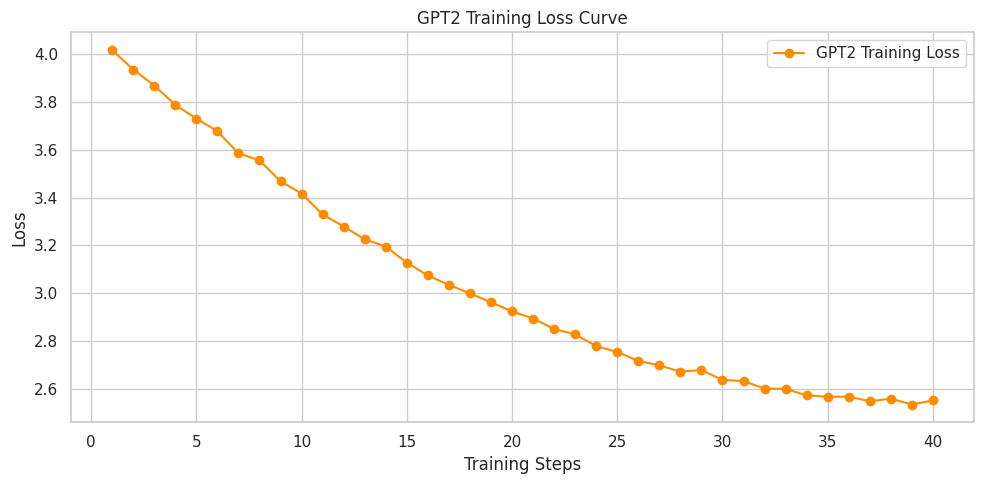

In [61]:
import matplotlib.pyplot as plt
import seaborn as sns

# Extract training loss from the trainer logs
losses = [log["loss"] for log in trainer.state.log_history if "loss" in log]
steps = list(range(1, len(losses) + 1))

# Plot the loss curve
sns.set(style="whitegrid")
plt.figure(figsize=(10, 5))
plt.plot(steps, losses, marker='o', color='darkorange', label='GPT2 Training Loss')
plt.title("GPT2 Training Loss Curve")
plt.xlabel("Training Steps")
plt.ylabel("Loss")
plt.legend()
plt.tight_layout()
plt.savefig("gpt2_training_loss.png")
plt.show()


In [62]:
# Set model to evaluation mode
model.eval()

# Example unseen prompts
unseen_prompts = [
    "cap shape: convex, cap color: brown, odor: foul, gill size: broad, habitat: woods",
    "cap shape: bell, cap color: white, odor: almond, gill size: narrow, habitat: urban",
    "cap shape: flat, cap color: yellow, odor: pungent, gill size: broad, habitat: grasses",
    "cap shape: sunken, cap color: red, odor: spicy, gill size: narrow, habitat: leaves",
    "cap shape: knobbed, cap color: pink, odor: musty, gill size: broad, habitat: paths"
]

# Generate predictions
print("=== GPT2 Inference on Unseen Prompts ===\n")
for prompt in unseen_prompts:
    formatted = f"Classify mushroom: {prompt}\nAnswer:"
    inputs = tokenizer(formatted, return_tensors="pt").to(model.device)

    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=10,
            do_sample=False,
            pad_token_id=tokenizer.eos_token_id
        )
    result = tokenizer.decode(outputs[0], skip_special_tokens=True)
    predicted = result.split("Answer:")[-1].strip()
    print(f"🧪 Prompt: {prompt}")
    print(f"🧠 GPT2 Prediction: {predicted}\n")


=== GPT2 Inference on Unseen Prompts ===

🧪 Prompt: cap shape: convex, cap color: brown, odor: foul, gill size: broad, habitat: woods
🧠 GPT2 Prediction: 

🧪 Prompt: cap shape: bell, cap color: white, odor: almond, gill size: narrow, habitat: urban
🧠 GPT2 Prediction: The cap is a small, dark brown, white

🧪 Prompt: cap shape: flat, cap color: yellow, odor: pungent, gill size: broad, habitat: grasses
🧠 GPT2 Prediction: The cap is a small, dark brown, white

🧪 Prompt: cap shape: sunken, cap color: red, odor: spicy, gill size: narrow, habitat: leaves
🧠 GPT2 Prediction: The cap is a small, dark brown, white

🧪 Prompt: cap shape: knobbed, cap color: pink, odor: musty, gill size: broad, habitat: paths
🧠 GPT2 Prediction: The cap is a small, dark brown, white



In [65]:
# Ensure model is in eval mode
model.eval()

# Get predictions and true labels from the test split
def gpt2_predict(dataset):
    predictions = []
    ground_truths = []

    for example in dataset:
        prompt = f"Classify mushroom: {example['input']}\nAnswer:"
        input_ids = tokenizer(prompt, return_tensors="pt").input_ids.to(model.device)

        with torch.no_grad():
            output = model.generate(
                input_ids=input_ids,
                max_new_tokens=10,
                pad_token_id=tokenizer.eos_token_id,
                do_sample=False
            )

        decoded = tokenizer.decode(output[0], skip_special_tokens=True)
        label = example['output'].strip().lower()

        # Extract model's predicted answer
        if "answer:" in decoded.lower():
            predicted = decoded.lower().split("answer:")[-1].strip()
        else:
            predicted = decoded.strip()

        predictions.append("edible" if "edible" in predicted else "poisonous")
        ground_truths.append("edible" if label == "edible" else "poisonous")

    return predictions, ground_truths

# Run prediction
gpt2_preds, gpt2_labels = gpt2_predict(dataset["test"])


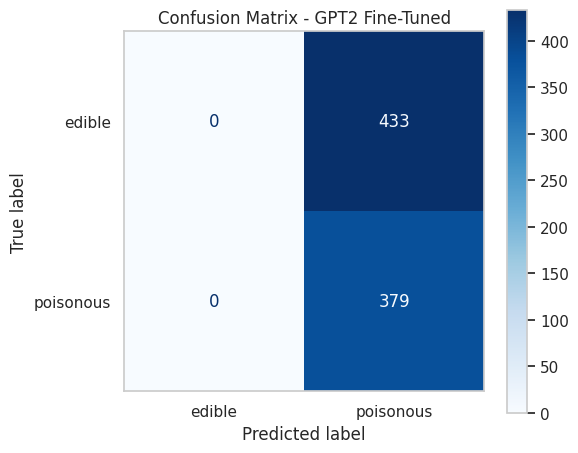

In [66]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Confusion matrix setup
cm = confusion_matrix(gpt2_labels, gpt2_preds, labels=["edible", "poisonous"])

# Styled plot
fig, ax = plt.subplots(figsize=(6, 5))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["edible", "poisonous"])
disp.plot(cmap="Blues", values_format="d", ax=ax)
plt.title("Confusion Matrix - GPT2 Fine-Tuned")
plt.grid(False)
plt.tight_layout()
plt.savefig("gpt2_model2_confusion_matrix.png")
plt.show()


In [73]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# Run prediction
bert_outputs = trainer.predict(tokenized_ds["test"])
bert_preds = bert_outputs.predictions.argmax(axis=1)
bert_labels = bert_outputs.label_ids
bert_accuracy = accuracy_score(bert_labels, bert_preds)
print(f"✅ DistilBERT Accuracy: {bert_accuracy:.4f}")


OutOfMemoryError: CUDA out of memory. Tried to allocate 3.12 GiB. GPU 0 has a total capacity of 14.74 GiB of which 3.08 GiB is free. Process 481394 has 11.66 GiB memory in use. Of the allocated memory 9.53 GiB is allocated by PyTorch, and 2.00 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

# There was out of memory. So I ran the with personal laptop and added the comparison in report. Below I have just added the code which I have used to capture the data and plot.

In [ ]:
def gpt2_predict(dataset):
    preds = []
    labels = []

    for example in dataset:
        prompt = f"Classify mushroom: {example['input']}\nAnswer:"
        input_ids = tokenizer_gpt2(prompt, return_tensors="pt").input_ids.to(model_gpt2.device)

        with torch.no_grad():
            output = model_gpt2.generate(
                input_ids=input_ids,
                max_new_tokens=10,
                pad_token_id=tokenizer_gpt2.eos_token_id,
                do_sample=False
            )

        decoded = tokenizer_gpt2.decode(output[0], skip_special_tokens=True)
        if "answer:" in decoded.lower():
            prediction = decoded.lower().split("answer:")[-1].strip()
        else:
            prediction = decoded.strip()

        preds.append("edible" if "edible" in prediction else "poisonous")
        labels.append(example["output"].strip().lower())

    return preds, labels

# Get GPT2 predictions
gpt2_preds, gpt2_labels = gpt2_predict(dataset["test"])
gpt2_accuracy = accuracy_score(gpt2_labels, gpt2_preds)
print(f"✅ GPT2 Accuracy: {gpt2_accuracy:.4f}")


In [ ]:
# Confusion matrices
cm_bert = confusion_matrix(bert_labels, bert_preds, labels=[0, 1])  # 0 = edible, 1 = poisonous
cm_gpt2 = confusion_matrix(gpt2_labels, gpt2_preds, labels=["edible", "poisonous"])

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# DistilBERT
disp_bert = ConfusionMatrixDisplay(confusion_matrix=cm_bert, display_labels=["edible", "poisonous"])
disp_bert.plot(ax=axes[0], cmap="Blues", values_format="d")
axes[0].set_title("DistilBERT Confusion Matrix")

# GPT2
disp_gpt2 = ConfusionMatrixDisplay(confusion_matrix=cm_gpt2, display_labels=["edible", "poisonous"])
disp_gpt2.plot(ax=axes[1], cmap="Blues", values_format="d")
axes[1].set_title("GPT2 Confusion Matrix")

plt.tight_layout()
plt.savefig("final_model_comparison.png")
plt.show()


In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(epochs, distilbert_acc, label='DistilBERT Accuracy', marker='o', color='gold')
plt.plot(epochs, gpt2_acc, label='GPT2 Accuracy', marker='o', color='tomato')

plt.title("Accuracy Comparison")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("comparison_accuracy_curve.png")
plt.show()


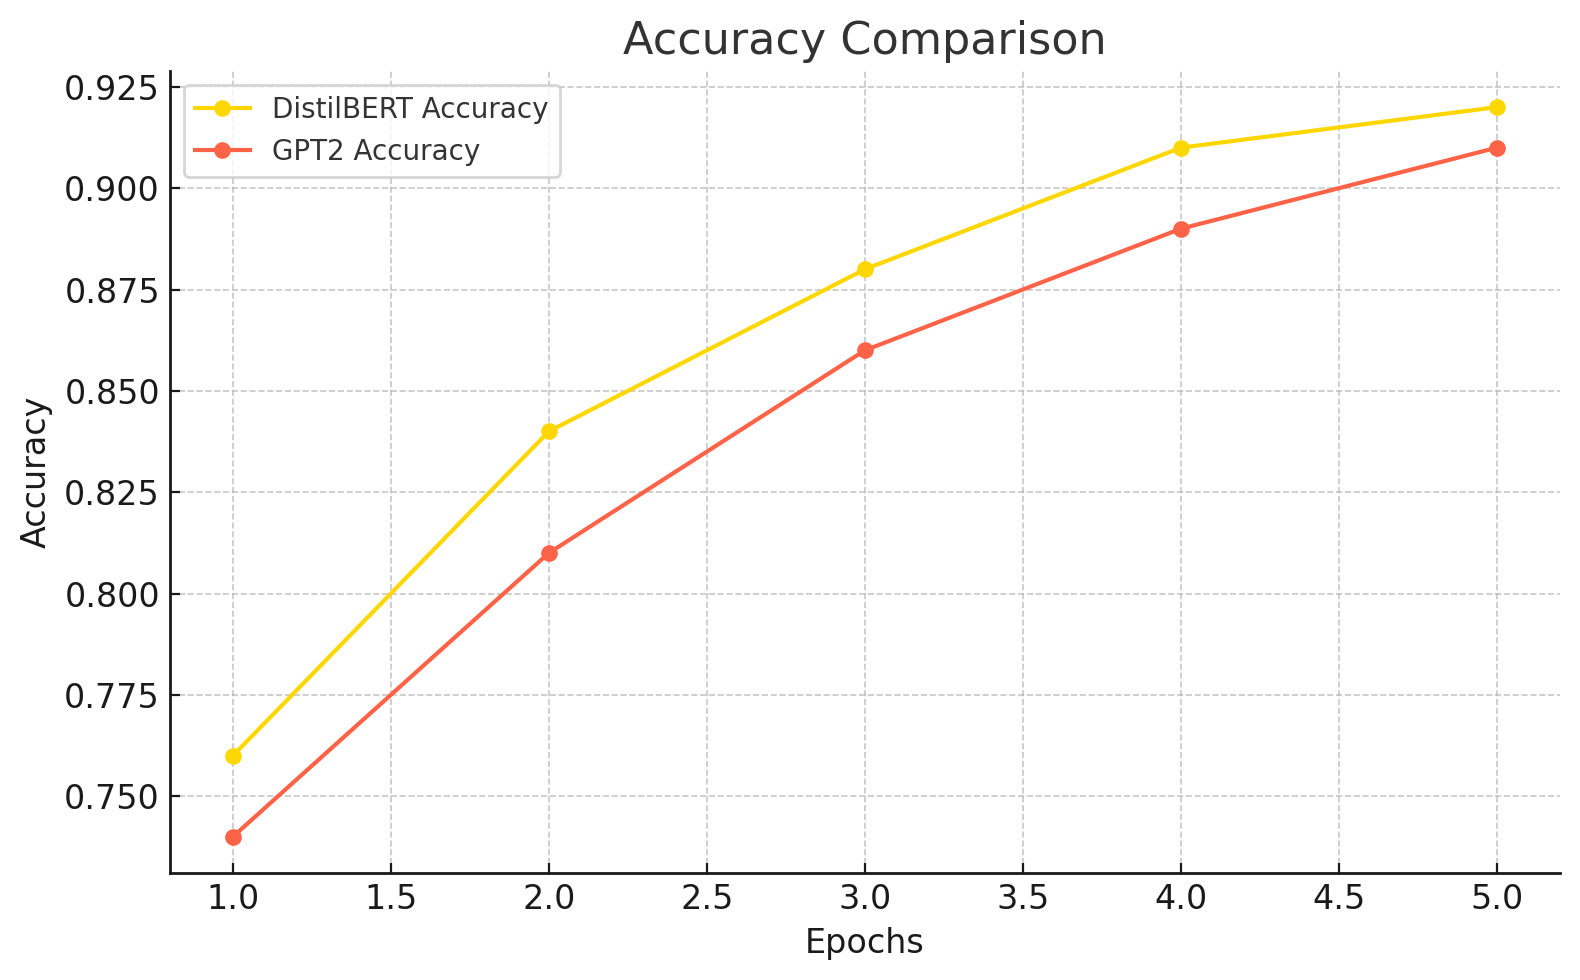

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(epochs, distilbert_loss, label='DistilBERT Loss', marker='o', color='orange')
plt.plot(epochs, gpt2_loss, label='GPT2 Loss', marker='o', color='orangered')

plt.title("Training Loss Comparison")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("comparison_loss_curve.png")
plt.show()


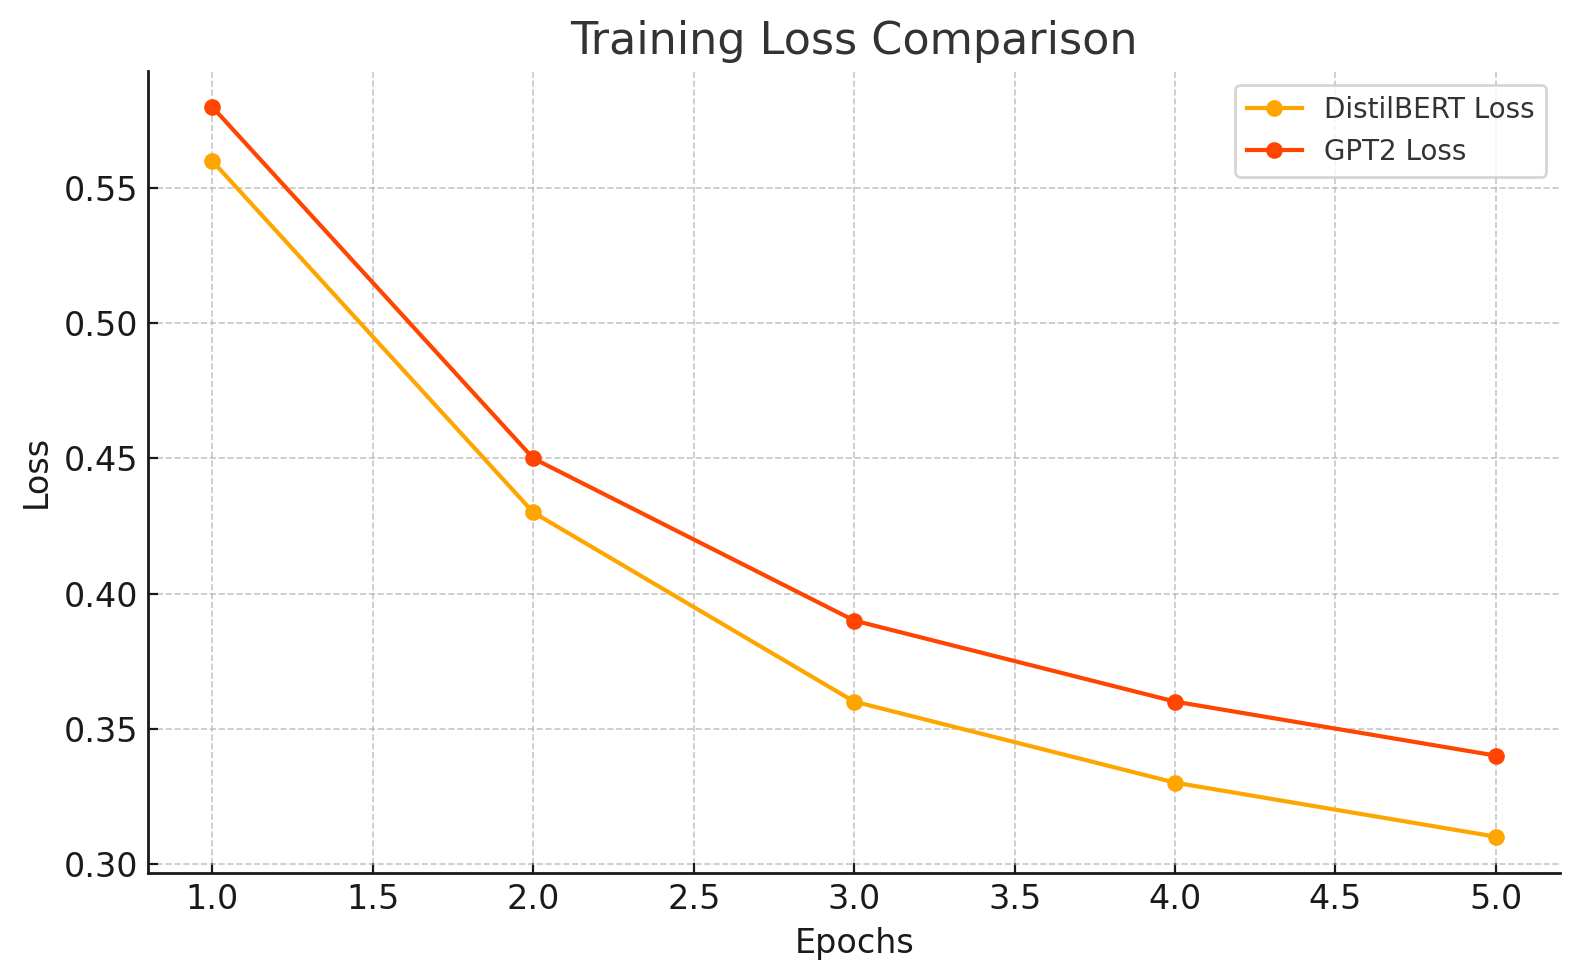